In [4]:
from __future__ import division
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import stats
import math


# turn of data table rendering
pd.set_option('display.notebook_repr_html', False)

sns.set_palette(['#00A99D', '#F5CA0C', '#B6129F', '#76620C', '#095C57'])
fill_color = '#F5CA0C'
np.version.full_version

'1.16.1'

## Data
In the example we take a random sample of 25 housing prices in our neighbourhood and compare them against the average price of a house in the whole country.

In [5]:
# data = np.random.random_sample(25) * 360000 + 100000 / floor it
housing_prices = pd.Series(
    [319711.,  289066.,  212512.,  195347.,  245589.,  418577., 
     301112.,  327251.,  434408.,  224529.,  450276.,  423406.,
     230321.,  275374.,  215945.,  209971.,  322661.,  292517.,
     378317.,  194028.,  347261.,  104542.,  231457.,  335174.,  
     369656.])
housing_prices.head()

0    319711.0
1    289066.0
2    212512.0
3    195347.0
4    245589.0
dtype: float64

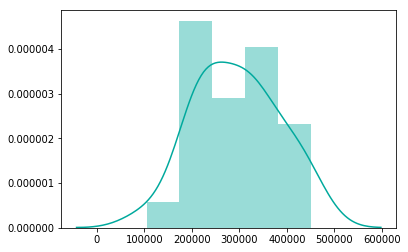

In [6]:
sns.distplot(housing_prices)
plt.show()

## Hypothesis
We want to know if there is a significant difference in the mean housing price, compared to the average price of a house in our country. The latter has a mean of $\mu=289.100$. We choose as our test criterium an alpha level of 5%. So our hypothesis states:

|Hypothesis||$\alpha = .05$|
|---:|:---:|---|:---|
|$H_0:$|$\bar{x} = \mu$|There is no significant difference in mean housing price|
|$H_a:$|$\bar{x} \neq \mu$|There is a significant difference in the mean housing price|


In [7]:
# The mean housing price is a given
mu = 289100.
mu

289100.0

In [8]:
# The sample statistics
n = housing_prices.count()
xbar = housing_prices.mean()
s = housing_prices.std(ddof=1)
n, xbar, s

(25, 293960.32, 88348.43221383916)

In [9]:
# Show the mean difference
xbar - mu

4860.320000000007

It looks like the housing prices in our neighbourhood are slightly higher than the average price of a house in the whole country. But is a  4860.32 difference significant? 

## The t-distribution
Since we don't know the standard deviation of the population, we can't use the the standard normal distribution to perform our hypothesis test. If we don't know this population parameter we us the t-distribution. The shape of the t-distribution is closely related to the degress of freedom we have in the dataset. For a series (like we have here) this is $n-1$. Below a plot of the difference in shape from the normal distribution.

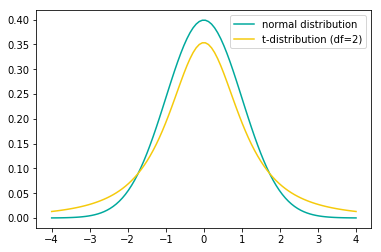

In [10]:
# Plot the normal distribution
samples = 100
dof = 2
x_plot = np.linspace(-4, 4, samples)
y_plot = stats.norm.pdf(x_plot, 0, 1)
plt.plot(x_plot, y_plot)

x_plot = np.linspace(-4, 4, samples)
y_plot = stats.t.pdf(x_plot, dof)
plt.plot(x_plot, y_plot)

# Show legend
plt.legend(['normal distribution', 't-distribution (df=2)'])
plt.show()

## Effect of increased degrees of freedom
The t-distribution tends to grow towards the normal distribution when the degrees of freedom increase. If we have a sample size bigger than $n=30$, the differences between the t and normal distribution are very small. Below a projection of the effect on the t-distribution while increasing the degrees of freedom from 1, 4, 14 to 29.

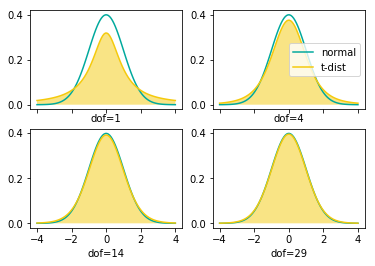

In [11]:
f, (ax1, ax2) = plt.subplots(2, 2, sharex=True)
axes = [ax1[0], ax1[1], ax2[0], ax2[1]]
ax = 0

samples = 100
degrees_of_freedom = [1, 4, 14, 29]

for dof in degrees_of_freedom:
    x_plot = np.linspace(-4, 4, samples)
    y_plot = stats.norm.pdf(x_plot, 0, 1)
    axes[ax].plot(x_plot, y_plot)

    y_fill = stats.t.pdf(x_plot, dof)
    axes[ax].fill_between(x_plot,  y_fill, alpha=.5, facecolor=fill_color) 
    
    y_plot = stats.t.pdf(x_plot, dof)
    axes[ax].plot(x_plot, y_plot)
    axes[ax].set_xlabel('dof=' + str(dof))
    
    ax += 1  
    
axes[1].legend(['normal', 't-dist'])
plt.show()

## The one-sample t-test
Let's find out what out t-statistic related to our sample mean. We use the follwing formula:

$$t=\frac{\bar{x}-\mu}{s\cdot\sqrt{n}}$$

In [12]:
# Calculate the t-statistic for the sample mean
se = s / math.sqrt(n)
t_statistic = (xbar - mu) / se
t_statistic

0.2750654356964737

In [13]:
# What is the probability of getting this mean?
p = stats.t.sf(t_statistic, dof) * 2. # two-sided test 
p

0.7852162672614891

In [14]:
# To test our alternative hypothesis
alpha = .05
p < alpha / 2 #two sided

False

So we fail to reject the null hypothesis. A mean difference of 4860.32 in housing prices between our neigbourhood and the whole country is not significant.

In [15]:
# To perform a t-test more quickly, we can use scipy.stats ttest_1samp
# for a one-sample t-test. The function returns the t-statistic and 
# the p-value in one single call. Slightly different results, but close
t_statistic, p = stats.ttest_1samp(housing_prices, mu)
t_statistic, p

(0.2750654356964736, 0.7856201417078766)

## Cohen's d effect size
Cohen's d is an effect size measure. According to Wikipedia, in statistics, an [effect size](http://en.wikipedia.org/wiki/Effect_size) is a quantitative measure of the strength of a phenomenon. Cohen's d is the standardized mean difference that measures the distance between two means in standard units (standard deviations). The larger the result (positive or negative), the larger the effect. Rule of thumb; small (0.2), medium (0.5) and large (0.8). Click the link to see a great interactive visualization on [Interpreting Cohen's d effect size](http://rpsychologist.com/d3/cohend/). The formula for Cohen's d is as follows:


$$Cohen's\ d=\frac{\bar{x}-\mu}{s}$$

In [16]:
# Calculate Cohen's d
d = (xbar - mu) / s
d

0.05501308713929473

This is a very small effect, acording to our rule of thumb stated above. The two mean are only 0.055 standard deviations apart.

## Confidence interval
In addition to our test result, we want to calculate an interval in which our population parameter will probably lie. In this case the true average housing price in our neighbourhood. With the t-statistic we just calculated, we can calculate a 95% confidence interval.

In [17]:
# Calculate the 95% confidence interval
dof = n - 1
t_critical = abs(stats.t.ppf(alpha / 2, dof)) # two sided
margin_of_error = t_critical * se

CI_lower =  xbar - margin_of_error
CI_upper =  xbar + margin_of_error
CI_lower, CI_upper

(257491.87956635334, 330428.7604336467)

This means that we are for 95% certain that the true mean housing price in our neighborhood lies between 257.491 and 330.428.